# Controlling the `datashader` pipeline

`datashader` is a flexible Python library designed to expose the stages involved in generating a visualization.  These stages can then be automated, configured, customized, or replaced wherever appropriate for a data analysis task.  The main stages in a datashader pipeline are similar to those in a [3D graphics rendering pipeline](https://en.wikipedia.org/wiki/Graphics_pipeline):

![pipeline diagram](https://raw.githubusercontent.com/bokeh/datashader/master/docs/images/pipeline2.png)

Here the computational steps are listed across the top of the diagram, while the data structures or objects are listed along the bottom.  This pipeline provides all of the power of `datashader`, because only the first couple of stages require the full dataset, and the remaining stages use a fixed-sized data structure regardless of the input dataset, making it practical to work with even extremely large datasets.

In this notebook, we'll first put together a simple, artificial example to get some data, and then show how to configure and customize each of the data-processing stages involved:

1. [Projection](#Projection)
2. [Aggregation](#Aggregation)
3. [Transformation](#Transformation)
4. [Colormapping](#Colormapping)
5. [Embedding](#Embedding)

## Data

For an example, we'll construct a dataset made of five overlapping 2D Gaussian distributions.  It's an example introduced in plotting_pitfalls.ipynb, but now with category labels defined, to help us separate the different components.  

By default we'll have 10,000 datapoints from each category, but you should see sub-second response times even for 1 million datapoints per category if you increase `num`. 

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf
from collections import OrderedDict

np.random.seed(1)
num=10000

dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,s,num),
                                y=np.random.normal(y,s,num),
                                val=val,cat=cat))
         for x,y,s,val,cat in 
         [(2,2,0.01,10,"d1"), (2,-2,0.1,20,"d2"), (-2,-2,0.5,30,"d3"), (-2,2,1.0,40,"d4"), (0,0,3,50,"d5")]}

df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

,cat,val,x,y
49995,d5,50,-1.397579,0.610189
49996,d5,50,-2.649610,3.080821
49997,d5,50,1.933360,0.243676
49998,d5,50,4.306374,1.032139
49999,d5,50,-0.493567,-2.242669


We now have data in a [Pandas](http://pandas.pydata.org) dataframe.  datashader can accept data in any dataframe-like object, such as those provided by [dask](http://dask.pydata.org) and [blaze](http://blaze.pydata.org), so we'll be able to use this object directly. In the sections below, we'll look at each of the stages involved in plotting this data. For now, let's just dump the x,y coordinates into an image using all the default settings:

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 234 ms


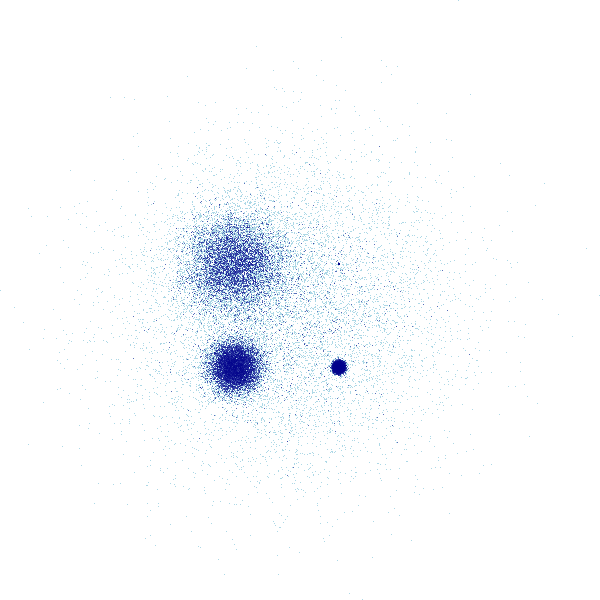

In [3]:
%time tf.shade(ds.Canvas().points(df,'x','y'))

As you can see, datashader is able to reveal the overall shape of this distribution faithfully: four summed 2D normal distributions of different variances, arranged at the corners of a square, overlapping another very high-variance 2D normal distribution centered in the square.  This structure is clear without needing to adjust or tune any parameters, which is a great starting point, but you can then customize each of the various stages involved as described below.

## Projection

datashader is designed to render datasets projected on to a 2D rectangular grid, eventually generating an image where each pixel corresponds to one cell in that grid.   The ***Projection*** stage includes several steps:

- Select which variable you want to have on the *x* axis, and which one for the *y* axis.  If those variables are not already columns in your dataframe (e.g. if you want to do a coordinate transformation), you'll need to create suitable columns mapping directly to *x* and *y* for use in the next step.  For this example, the "x" and "y" columns are conveniently named `x` and `y` already, but any column name can be used for these axes.
- Choose a glyph, which determines how an incoming datapoint maps onto the rectangular grid.  There are two glyphs provided with the library: a `Point` glyph, which will map the datapoint into the single closest grid cell to that datapoint's location, and a `Line` glyph that maps that point into every grid cell falling between this point and the next.  You can create other `Glyph` types for custom purposes, such as shading a point onto a set of bins according to some kernel function or some uncertainty value, although implementing a new glyph is more difficult than customizing the other components of the pipeline. Simple example of using a `Point`:

In [4]:
glyph = ds.glyphs.Point('x', 'y')

- Decide what size final image you want (in pixels), and what range of the data to plot (in whatever units `x` and `y` are stored), and create a `Canvas` object to hold this information.  E.g., for a 200x200 image covering the range plus or minus 8 on both axes, you would do:

In [5]:
canvas = ds.Canvas(plot_width=200, plot_height=200, x_range=(-8,8), y_range=(-8,8))

At this stage, no computation has actually been done -- the `glyph` and `canvas` objects are purely declarative objects that record your preferences, which won't actually be applied until the next stage. Thus the ***Projection*** stage is primarily conceptual--how do you want your data to be mapped for aggregation, when it is (later) aggregated?  The **Scene** object suggested above is not actually constructed in memory, but it conceptually corresponds to what other plotting packages would render directly to the screen at this stage.


## Aggregation

Once a (conceptual) **Scene** object has been specified, it can then be used to guide aggregating the data into a fixed-sized grid.  All of the aggregation options currently supported are implemented as incremental reduction operators.  Using incremental operations means that we can efficiently process datasets in a single pass, which is particularly important for datasets larger than the memory available.  Given an aggregate bin to update (typically corresponding to one eventual pixel) and a new datapoint, the reduction operator updates the state of the bin in some way. (Actually, datapoints are normally processed in batches for efficiency, but it's simplest to think about the operator as being applied per data point, and the mathematical result should be the same.) A large number of useful [reduction operators]((http://datashader.readthedocs.org/en/latest/api.html#reductions) are supplied in `ds.reductions`, including:

**`count(column=None)`**:
  increment an integer count each time a datapoint maps to this bin.
  
**`any(column=None)`**:
  the bin is set to 1 if any datapoint maps to it, and 0 otherwise.
  
**`sum(column)`**:
  add the value of the given column for this datapoint to a running total for this bin.
   
**`count_cat(column)`**:
  given a bin with categorical data (i.e., [Pandas' `categorical` datatype](https://pandas-docs.github.io/pandas-docs-travis/categorical.html)), count each category separately, adding the given datapoint to an appropriate category within this bin.  These categories can later be collapsed into a single count if needed; see example below.
  
**`summary(name1=op1,name2=op2,...)`**:
  allows multiple reduction operators to be computed in a single pass over the data; just provide a name for each resulting aggregate and the corresponding reduction operator to use when creating that aggregate.
  
The API documentation contains the complete list of [reduction operators]((http://datashader.readthedocs.org/en/latest/api.html#reductions) provided, including `mean`, `min`, `max`, `var` (variance), `std` (standard deviation).
  
You can also create your own reduction operators, following those examples. These components are highly optimized and thus the code is perhaps a bit hard to follow, but anything mathematically similar to the above choices should be reasonably straightforward to implement.  

For the operators above, those accepting a `column` argument will only do the operation if the value of that column for this datapoint is not `NaN`.  E.g. `count` with a column specified will count the datapoints having non-`NaN` values for that column.

To compute the aggregation for each pixel-sized aggregate bin using your selected reduction operator, you can use the `bypixel` function:

In [6]:
from datashader import reductions
reduction = reductions.count()

from datashader.core import bypixel
agg = bypixel(df, canvas, glyph, reduction)
agg

<xarray.DataArray (y_axis: 200, x_axis: 200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y_axis   (y_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...
  * x_axis   (x_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...

The result of the `bypixel` call will be an [xarray](http://xarray.pydata.org) `DataArray` data structure containing the bin values (typically one value per bin, but more for multiple category or multiple-aggregate operators) and axis range and type information.  Because nearly all current plot types use glyphs of type `Point` or `Line`, there's also a shortcut syntax provided that will go straight to aggregation by `point` or `line` from the canvas object, hiding the `bypixel()` call and the glyph object creation:

In [7]:
canvas.points(df, 'x', 'y', agg=reductions.count())

<xarray.DataArray (y_axis: 200, x_axis: 200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y_axis   (y_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...
  * x_axis   (x_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...

This concise syntax is what we use throughout the examples, including in the cells below, but the more verbose syntax introduced above is needed if you want to define your own custom `Glyph` types, and we introduced it first here to help clarify what steps are involved. 

We can visualize this array in many different ways by customizing the pipeline stages described in the following sections, but for now we'll just dump it into an image using the default parameters to show the effects of a few different aggregate operators:

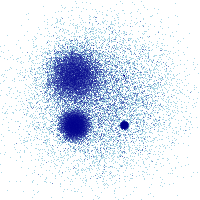

In [8]:
tf.shade(canvas.points(df,'x','y',agg=reductions.count()))

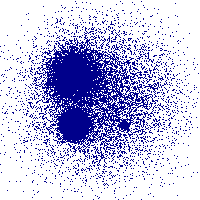

In [9]:
tf.shade(canvas.points(df,'x','y',agg=reductions.any()))

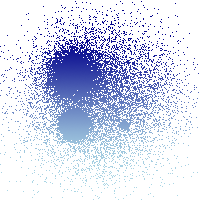

In [10]:
tf.shade(canvas.points(df,'x','y',agg=reductions.mean('y')))

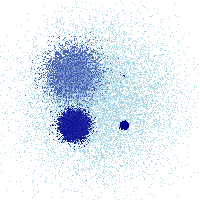

In [11]:
tf.shade(50-canvas.points(df,'x','y',agg=reductions.mean('val')))

For the last image above, we specified that the `val` column should be used for the `mean` reduction, which in this case results in each category being assigned a different color, because in our dataset all items in the same category happen to have the same `val`.  But as the previous image shows, we can specify any column we like for the aggregation, including the `y` value as in that image. We can also manipulate the result of the aggregation before displaying it (here by inverting it by subtracting it from 50), as detailed in the next section.



## Transformation

Now that the data has been projected and aggregated into a gridded data structure, it can be processed in any way you like, before converting it to an image as will be described in the following section.  At this stage, the data is still stored as bin data, not pixels (despite the `bypixel` name above :-), which makes a very wide variety of operations and transformations simple to express.  

For instance, instead of plotting all the data, we can easily plot only those bins in the 99th percentile by count:

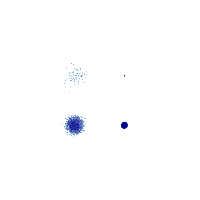

In [12]:
agg  = canvas.points(df, 'x', 'y')
tf.shade(agg.where(agg>=np.percentile(agg,99)))

Or apply any [NumPy ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) to the bin values, whether or not it makes any sense:

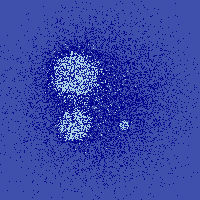

In [13]:
tf.shade(np.sin(agg))

The [xarray documentation](http://xarray.pydata.org/en/stable/computation.html) describes all the various transformations you can apply from within xarray, and of course you can always extract the data values and operate on them outside of xarray for any transformation not directly supported by xarray, then construct a suitable xarray object for use in the following stage.  Once the data is in the aggregate array, you generally don't have to worry much about optimization, because it's a fixed-sized grid regardless of your data size, and so it is very straightforward to apply arbitrary transformations to the aggregates.

The above examples focus on a single aggregate, but there are many ways that you can use multiple data values per bin as well.  For instance, if you collect categorical data, you will have an aggregate value for each category for each bin:

In [14]:
aggc = canvas.points(df, 'x', 'y', ds.count_cat('cat'))
aggc

<xarray.DataArray (y_axis: 200, x_axis: 200, cat: 5)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ..., 
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ..., 
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ..., 
       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ..., 
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ..., 
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int32)
Coordinates:
  * y_axis   (y_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...
  * x_axis   (x_axis) float64 -8.0 -7.92 -7.839 -7.759 -7.678 -7.598 -7.518 ...
  * cat      (cat) <U2 'd1' 'd2' 'd3' 'd4' 'd5'

Currently only counts are supported for categories, but other reduction operators can be implemented as well (a [to-do item](https://github.com/bokeh/datashader/issues/140)).

You can then select a specific category or subset of them for further processing, where `.sum(dim='cat')` will collapse across such a subset to give a single aggregate array:

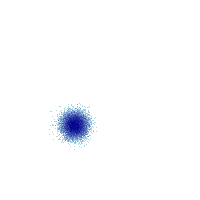

In [15]:
tf.shade(aggc.sel(cat='d3'))

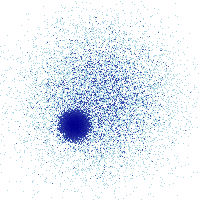

In [16]:
agg_d3_d5=aggc.sel(cat=['d3', 'd5']).sum(dim='cat')
tf.shade(agg_d3_d5)

You can also combine multiple aggregates however you like, as long as they were all constructed using the same Canvas object (which ensures that their aggregate arrays are the same size) and cover the same axis ranges:

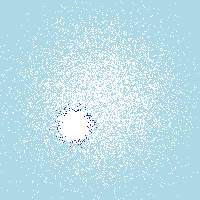

In [17]:
tf.shade(agg_d3_d5.where(aggc.sel(cat='d3') == aggc.sel(cat='d5')))

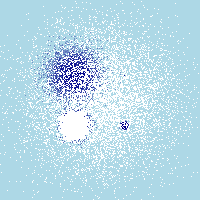

In [18]:
tf.shade(agg.where(aggc.sel(cat='d3') == aggc.sel(cat='d5')))

The above two results are using the same mask (only those bins `where` the counts for 'd3' and 'd5' are equal), but applied to different aggregates (either just the `d3` and `d5` categories, or the entire set of counts).

## Colormapping

As you can see above, the usual way to visualize an aggregate array is to map from each array bin into a color for a corresponding pixel in an image.  The above examples use the `tf.shade()` method, which maps a scalar aggregate bin value into an RGB (color) triple and an alpha (opacity) value.  By default, the colors are chosen from the colormap ['lightblue','darkblue'] (i.e., `#ADD8E6` to `#00008B`), with intermediate colors chosen as a linear interpolation independently for the red, green, and blue color channels (e.g. `AD` to `00` for the red channel, in this case).  The alpha (opacity) value is set to 0 for empty bins and 1 for non-empty bins, allowing the page background to show through wherever there is no data.  You can supply any colormap you like, including Bokeh palettes, Matplotlib colormaps, or a list of colors (using the color names from `ds.colors`, integer triples, or hexadecimal strings):

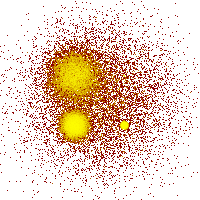

In [19]:
tf.shade(agg, cmap=["darkred", "yellow"])

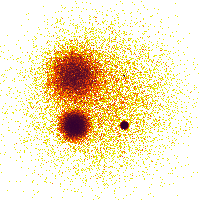

In [20]:
tf.shade(agg,cmap=[(230,230,0), "orangered", "#300030"]) # yellow, orange red, dark purple

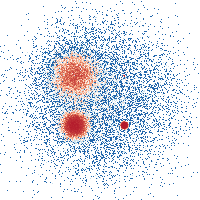

In [21]:
from bokeh.palettes import RdBu9
tf.shade(agg,cmap=RdBu9)

#### Colormapping categorical data

If you want to use `tf.shade` with a categorical aggregate, you can use a colormap just as for a non-categorical aggregate if you first select a single category using something like `aggc.sel(cat='d3')` or else collapse all categories into a single aggregate using something like
`aggc.sum(dim='cat')`.  Or you can instead use `tf.shade` with the categorical aggregate directly, which will assign a color to each category and then mix the colors according to the values of each category:

/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


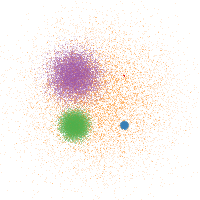

In [22]:
tf.shade(aggc)

Here the different colors mix not just on the page, but per pixel, with pixels having non-zero counts from multiple categories taking intermediate color values.  The actual data values are used to calculate the alpha channel, with this computed color being revealed to a greater or lesser extent depending on the value of the aggregate for that bin.  

The default color key for categorical data provides distinguishable colors for a couple of dozen categories, but you can provide an explicit color_key if you prefer:

/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


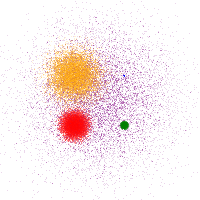

In [23]:
color_key = dict(d1='blue', d2='green', d3='red', d4='orange', d5='purple')
tf.shade(aggc, color_key=color_key)

Choosing colors for different categories is more of an art than a science, because the colors not only need to be distinguishable, their combinations also need to be distinguishable if those categories ever overlap in nearby pixels, or else the results will be ambiguous.  In practice, only a few categories can be reliably distinguished in this way, but zooming in (as shown below) can be used to help disambiguate overlapping colors, as long as the basic set of colors is itself distinguishable.


#### Transforming data values for colormapping

In each of the above examples, you may have noticed that we never needed to specify any parameters about the data values; the plots just appear like magic.  That magic is implemented in `tf.shade`.  What `tf.shade` does for a 2D aggregate (non-categorical) is:

1. **Mask** out all bins with a `NaN` value (for floating-point arrays) or a zero value (for integer arrays); these bins will not have any effect on subsequent computations.  Unfortunately, integer arrays do not support `NaN`; using zero as a pseudo-`NaN` works well for counts but not for all integer data, which is something that may need to be generalized in a future version of the library (a [to-do item](https://github.com/bokeh/datashader/issues/142)).

2. **Transform** the bin values using a specified scalar function `how`.  Calculates the value of that function for the difference between each bin value and the minimum non-masked bin value.  E.g. for `how="linear"`, simply returns the difference unchanged.  Other `how` functions are discussed below.

3. **Map** the resulting transformed data array into the provided colormap.  First finds the value span (*l*,*h*) for the resulting transformed data array -- what are the lowest and highest non-masked values?  -- and then maps the range (*l*,*h*) into the full range of the colormap provided.  Masked values are given a fully transparent alpha value, and non-masked ones are given a fully opaque alpha value.

The result is thus auto-ranged to show whatever data values are found in the aggregate bins (though the `span` argument can be used to set the range explicitly where appropriate).

As described in plotting_pitfalls.ipynb, auto-ranging is only part of what is required to reveal the structure of the dataset; it's also crucial to automatically and potentially nonlinearly map from the aggregate values (e.g. bin counts) into the colormap. If we used a linear mapping, we'd see very little of the structure of the data:

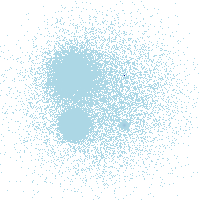

In [24]:
tf.shade(agg,how='linear')

In the linear version, you can see that the bins that have zero count show the background color, since they have been masked out using the alpha channel of the image, and that the rest of the pixels have been mapped to colors near the bottom of the colormap.  If you peer closely at it, you may even be able to see that one pixel (from the smallest Gaussian) has been mapped to the highest color in the colormap (here dark blue).  But no other structure is visible, because the highest-count bin is so much higher than all of the other bins:

In [25]:
top15=agg.values.flat[np.argpartition(agg.values.flat, -15)[-15:]]
print(sorted(top15))
print(sorted(np.round(top15*255.0/agg.values.max()).astype(int)))

[236, 278, 279, 350, 351, 416, 516, 527, 607, 646, 675, 784, 799, 933, 9974]
[6, 7, 7, 9, 9, 11, 13, 13, 16, 17, 17, 20, 20, 24, 255]


I.e., if using a colormap with 255 colors, the largest bin (`agg.values.max()`) is mapped to the highest color, but with a linear scale all of the other bins map to only the first 24 colors, leaving all intermediate colors unused.  If we want to see any structure for these intermediate ranges, we either need a fixed nonlinear scale, such as a logarithmic mapping:

[ 5.46806014  5.63121178  5.6347896   5.86078622  5.86363118  6.03308622
  6.24804287  6.26909628  6.41017488  6.47234629  6.51619308  6.66568372
  6.68461173  6.83947644  9.20783724]


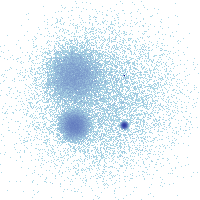

In [26]:
print(np.log1p(sorted(top15)))
tf.shade(agg,how='log')

or to show the ordering of pixel values, not the values themselves, which is the default since it is a non-parametric way to map the aggregated data values evenly onto the full range of visible colors (see plotting_pitfalls.ipynb):

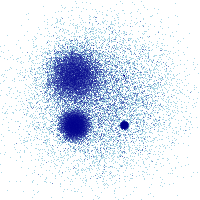

In [27]:
tf.shade(agg,how='eq_hist')

Custom `how` functions can also be supplied as a callable, such as this twenty-third root:

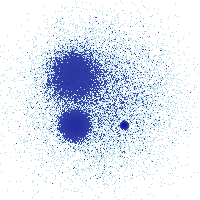

In [28]:
tf.shade(agg,how=lambda d, m: np.where(m, np.nan, d)**(1/23.))

Usually, however, such custom operations are done directly on the aggregate during the ***Transformation*** stage; the `how` operations are meant for simple, well-defined transformations solely for the final steps of visualization, which allows the main aggregate array to stay in the original units and scale in which it was measured.  Using `how` also helps simplify the subsequent ***Embedding*** stage, letting it provide one of a fixed set of legend types, either linear (for `how=linear`), logarithmic (for `how=log`) or percentile (for `how=eq_hist`).  See the [shade docs](http://datashader.readthedocs.org/en/latest/api.html#datashader.transfer_functions.shade) for more details on the `how` functions.  The `shade` function applies the `how` method similarly for categorical aggregates, based on the total across all categories, but then uses it for the alpha (opacity) channel of the image, rather than to index into a separate colormap. 


#### Spreading

Once an image has been created, it can be further transformed with a set of functions from `ds.transfer_functions`.

For instance, because it can be difficult to see individual dots, particularly for zoomed-in plots, you can transform the image to replace each non-transparent pixel with a shape, such as a circle (default) or square.  This process is called spreading:

/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


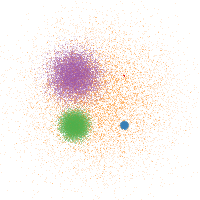

In [29]:
img = tf.shade(aggc)
img

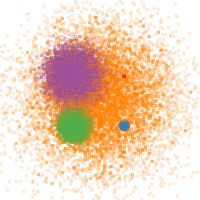

In [30]:
tf.spread(img)

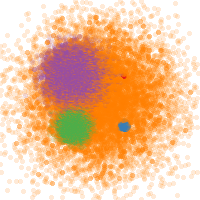

In [31]:
tf.spread(img, px=2)

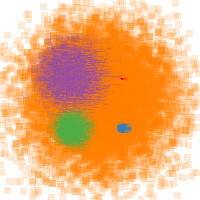

In [32]:
tf.spread(img, px=3, shape='square')

As you can see, spreading is very effective for isolated datapoints, which is what it's normally used for, but it has overplotting-like effects for closely spaced points like in the green and purple regions above, and so it would not normally be used when the datapoints are dense.

Spreading can be used with a custom mask, as long as it is square and an odd width and height (so that it will be centered over the original pixel):

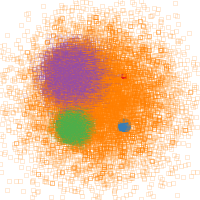

In [33]:
mask = np.array([[1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1]])

tf.spread(img, mask=mask)

To support interactive zooming, where spreading would be needed only in sparse regions of the dataset, we provide the dynspread function.  `dynspread` will dynamically calculate the spreading size to use by counting the fraction of non-masked bins that have non-masked neighbors; see the
[dynspread docs](http://datashader.readthedocs.org/en/latest/api.html#datashader.transfer_functions.dynspread) for more details.


#### Other image transfer_functions

Other useful image operations are also provided, such as setting the background color or combining images:

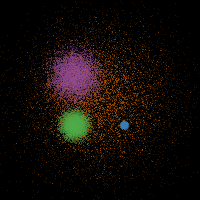

In [34]:
tf.set_background(img,"black")

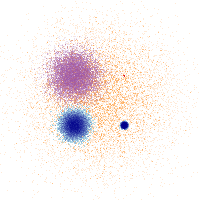

In [35]:
tf.stack(img,tf.shade(aggc.sel(cat=['d2', 'd3']).sum(dim='cat')))

In [38]:
tf.stack(img,tf.shade(aggc.sel(cat=['d2', 'd3']).sum(dim='cat')),how='saturate')

See [the API docs](http://datashader.readthedocs.org/en/latest/api.html#transfer-functions) for more details. Image composition operators to provide for the `how` argument of `tf.stack` (e.g. `over` (default), `source`, `add`, and `saturate`) are listed in [composite.py](https://raw.githubusercontent.com/bokeh/datashader/master/datashader/composite.py) and illustrated [here](http://cairographics.org/operators).

## Embedding

The above stages all eventually led to a raster image, displayed here using Jupyter's "rich display" support.  However, these images do not show the data ranges, axis labels, and so on, nor do they support the dynamic zooming and panning necessary to understand datasets across scales.  To add these features, the datashader output can be embedded into plots in a variety of plotting programs, such as an interactive [Bokeh](http://bokeh.pydata.org) plot:

In [39]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset,resize', x_range=(-5,5), y_range=(-5,5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('cat'))
    img = tf.shade(agg)
    return tf.dynspread(img, threshold=0.80)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
/home/kalidus/anaconda3/lib/python3.5/site-packages/datashader/transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


Here we've written a datashader pipeline as a function `image_callback` that generates an image object (try calling it yourself; e.g. `image_callback((-4,4),(-4,4),200,200)`), and provided that function to `InteractiveImage` (see [bokeh_ext.py](https://github.com/bokeh/datashader/blob/master/datashader/bokeh_ext.py)). `InteractiveImage`, in turn, works with any Bokeh figure, calling that function whenever the data range or plot size is changed by the interactive user.

If you enable the wheel zoom tool in the above plot (if you're running this notebook in a live server, not just a static export like on Anaconda Cloud), you can zoom and pan to explore each of the different regions of this dataset.  For instance, if you zoom in far enough on the red dot, you'll see that it does indeed include 10,000 points, they are just so close together that they show up as only a single tiny red spot here.  Such exploration is crucial for understanding datasets with rich structure across different scales, as in most real-world data.

`InteractiveImage` currently works only in a Jupyter notebook like this one, but `datashader` can be used analogously in any Bokeh plot, as illustrated in the dashboard app in the examples directory:

![screenshot](https://raw.githubusercontent.com/bokeh/datashader/master/docs/images/dashboard.png).

Similar interfaces can be developed for Matplotlib or other plotting packages; anything that can display an image should be able to use datashader output.  To try it out, install the library as described at the [github site](https://github.com/bokeh/datashader), and try out the notebooks and Python files in the examples directory.